Imports

In [15]:
!pip install hurst
!pip install pyinform

import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
from hurst import compute_Hc
from scipy import stats
import pyinform.transferentropy as te
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')  # This stops it showing warnings about "smaller than value shown."

Generate Data - note added noise for the trend up and down lines as many things don't work with perfectly aligned data.

In [4]:
# 1. Stationary - all same value
stationary = np.array([4]+[5] * 98 + [6])

# 2. Trending up - simple +1 increments
trending_up = np.arange(100) + np.random.normal(0, 0.5, 100)

# 3. Trending down - simple -1 decrements
trending_down = trending_up[::-1]  # Flip it to a down trend.

# 4. Cycling - simple sine wave pattern
cycling = np.array([0, 1, 2, 1, 0, -1, -2, -1] * 13)[:100]  # Repeat pattern

# 5. Exponential up - exponential growth
exponential_up = np.array([2**i for i in range(100)]) + np.random.normal(0, 1e5, 100)

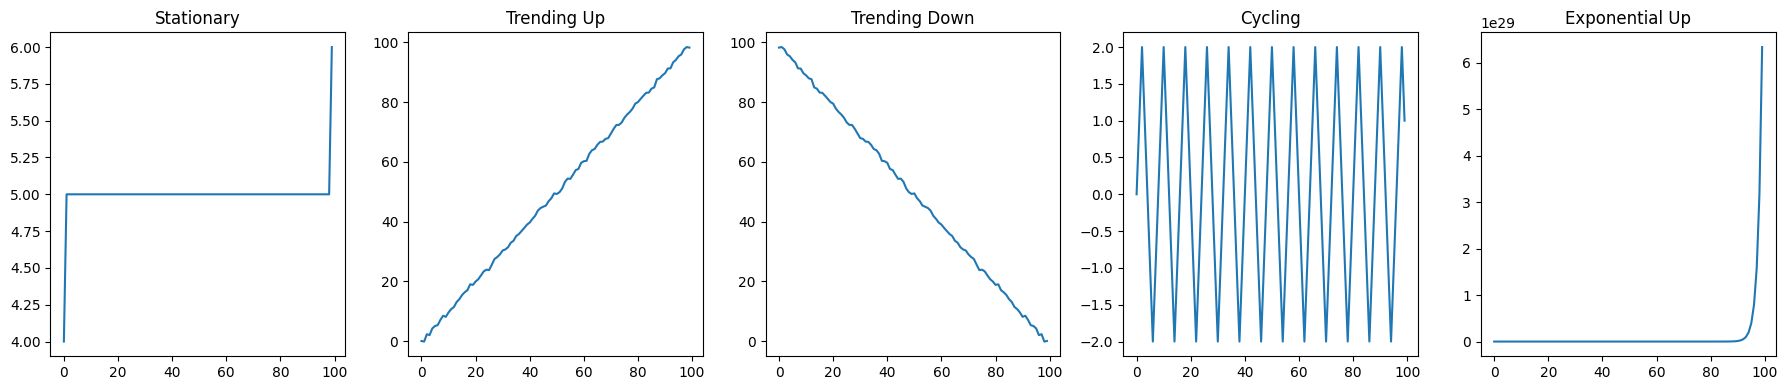

In [5]:
fig, axes = plt.subplots(1, 5, figsize=(18, 4))  # 1 row, 5 columns

axes[0].plot(stationary)
axes[0].set_title("Stationary")

axes[1].plot(trending_up)
axes[1].set_title("Trending Up")

axes[2].plot(trending_down)
axes[2].set_title("Trending Down")

axes[3].plot(cycling)
axes[3].set_title("Cycling")

axes[4].plot(exponential_up)
axes[4].set_title("Exponential Up")

plt.tight_layout()
plt.show()

Augmented Dickey-Fuller Test

In [6]:
result1 = adfuller(stationary)
result2 = adfuller(trending_up)
result3 = adfuller(trending_down)
result4 = adfuller(cycling)
result5 = adfuller(exponential_up)
print(f"Stationary P-Value: {result1[1]}")  # P-value < 0.05 then reject default hypothesis = stationary
print(f"Trending Up P-Value: {result2[1]}")  # P-value > 0.05 then accept default hypothesis = non-stationary
print(f"Trending Down P-Value: {result3[1]}")  # P-value > 0.05 then accept default hypothesis = non-stationary
print(f"Cycling P-Value: {result4[1]}")  # P-value < 0.05 then reject default hypothesis = stationary (cycling around a flat line)
print(f"Exponential Up P-Value: {result5[1]}")  # P-value > 0.05 then accept default hypothesis = non-stationary

Stationary P-Value: 8.1165643065793e-17
Trending Up P-Value: 0.953372577579823
Trending Down P-Value: 0.9682722350054215
Cycling P-Value: 0.0
Exponential Up P-Value: 1.0


Kwiatkowski-Phillips-Schmidt-Shin Test

In [7]:
# Regression='c' is like ADF test. Regression='ct' is trend stationary.
result1 = kpss(stationary, regression='ct')
result2 = kpss(trending_up, regression='ct')
result3 = kpss(trending_down, regression='ct')
result4 = kpss(cycling, regression='ct')
result5 = kpss(exponential_up, regression='ct')
print(f"Stationary P-Value: {result1[1]}")  # P-value > 0.05 then accept default hypothesis = trend-stationary (cycling around a flat line)
print(f"Trending Up P-Value: {result2[1]}")  # P-value > 0.05 then accept default hypothesis = trend-stationary (cycling around a flat line)
print(f"Trending Down P-Value: {result3[1]}")  # P-value > 0.05 then accept default hypothesis = trend-stationary (cycling around a flat line)
print(f"Cycling P-Value: {result4[1]}")  # P-value > 0.05 then accept default hypothesis = trend-stationary (cycling around a flat line)
print(f"Exponential Up P-Value: {result5[1]}")  # P-value < 0.05 then reject default hypothesis = non-trend stationary

Stationary P-Value: 0.1
Trending Up P-Value: 0.1
Trending Down P-Value: 0.1
Cycling P-Value: 0.1
Exponential Up P-Value: 0.030749875769875982


Hurst Exponent

In [9]:
result1 = compute_Hc(stationary)
result2 = compute_Hc(trending_up)
result3 = compute_Hc(trending_down)
result4 = compute_Hc(cycling)
result5 = compute_Hc(exponential_up)

print(f"Stationary P-Value: {result1[0]}")  # H > 0.5 = linear trend [but is close to 0.5, so closer to a random walk]
print(f"Trending Up P-Value: {result2[0]}")  # H > 0.5 = linear trend
print(f"Trending Down P-Value: {result3[0]}")  # H > 0.5 = linear trend
print(f"Cycling P-Value: {result4[0]}")  # H < 0.5 = mean reversion (cycling)
print(f"Exponential Up P-Value: {result5[0]}")  # H > 0.5 = linear trend [but is close to 0.5, so closer to a random walk]

# Horizontal trends or exponential trends will appear as a random walk because the function isn't really equipped to handle it.



Stationary P-Value: 0.6418893895475476
Trending Up P-Value: 1.0012116536716653
Trending Down P-Value: 0.9892705727267518
Cycling P-Value: 0.020364999245466597
Exponential Up P-Value: 0.5248351553409693


Fourier Analysis / Transform

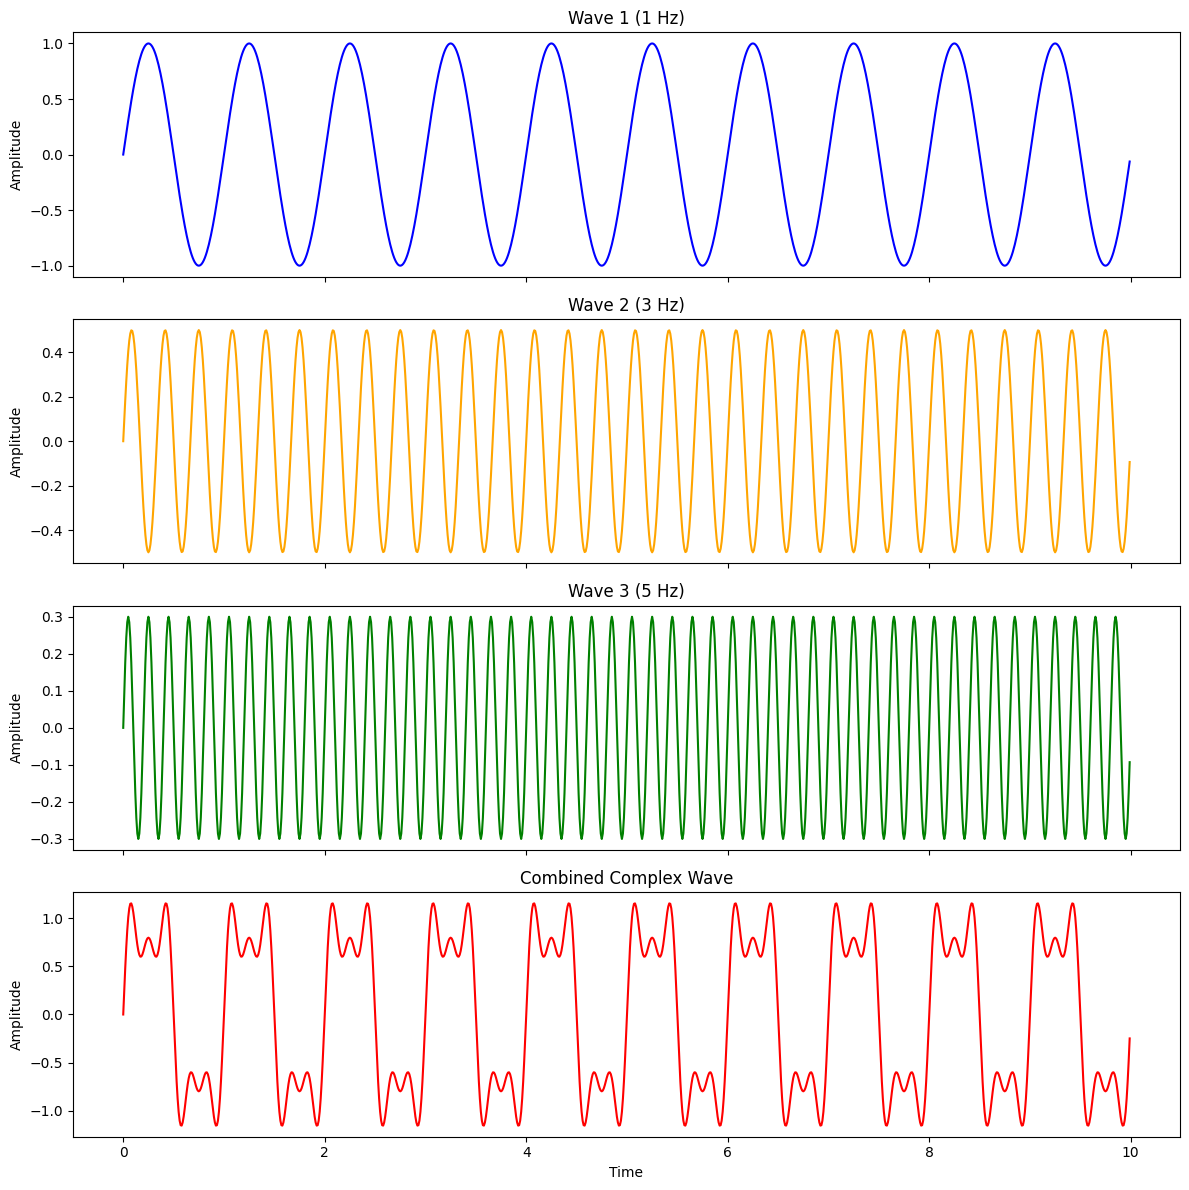

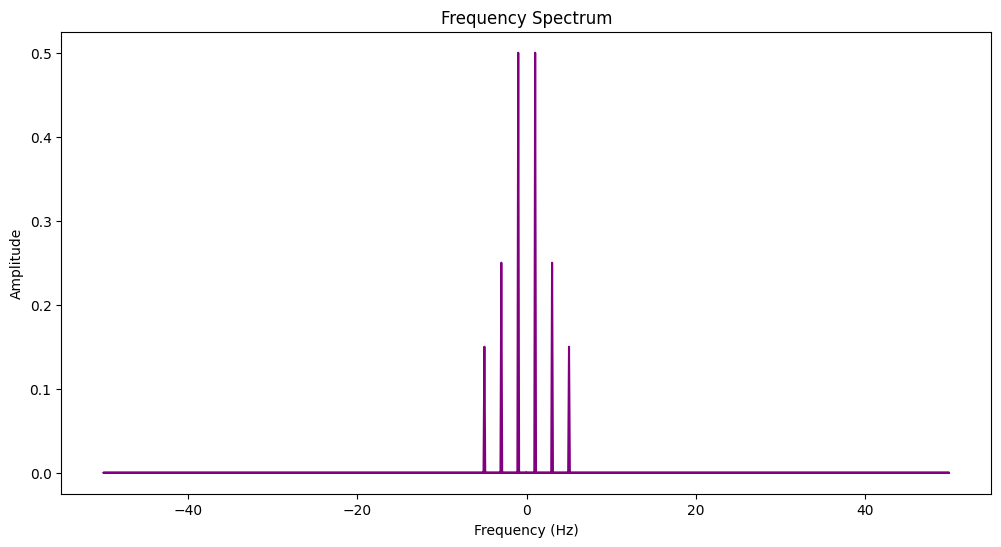

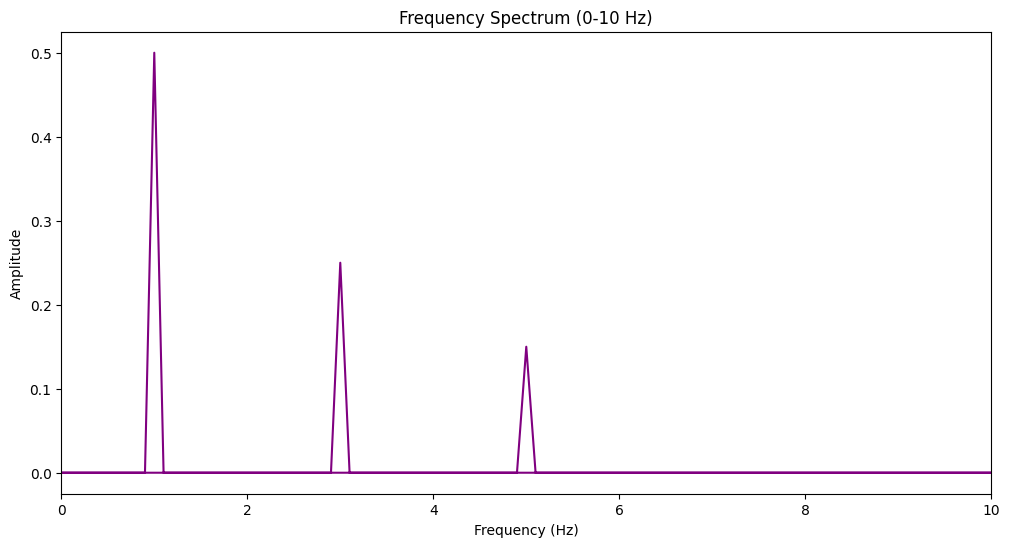

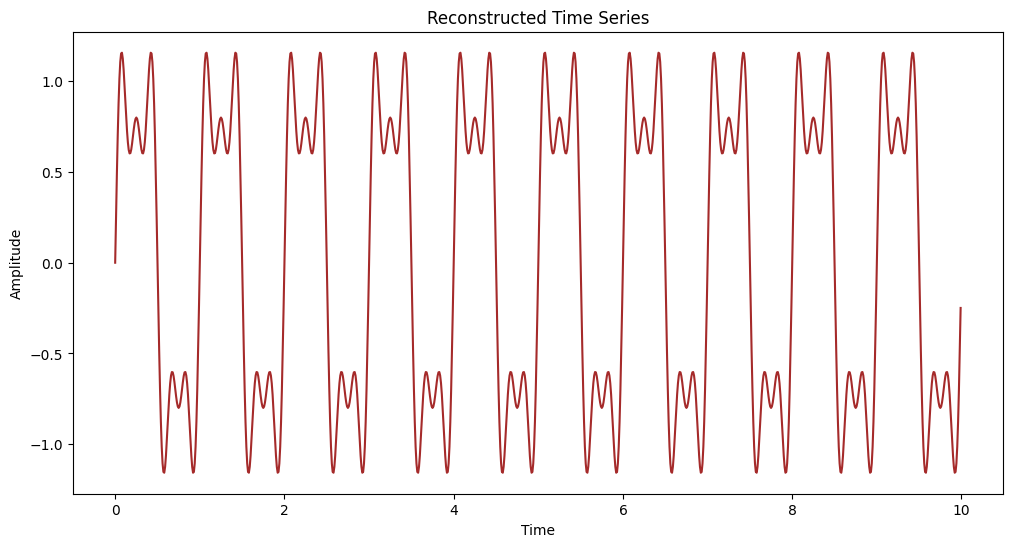

In [11]:
# Create time scale
time = np.arange(0, 10, 0.01)  # start 0, end 10, in steps of 0.1

# Create 3 waves with amplitudes 1, 0.5, 0.3
wave1 = 1.0 * np.sin(2 * np.pi * 1 * time)   # 1 Hz
wave2 = 0.5 * np.sin(2 * np.pi * 3 * time)   # 3 Hz
wave3 = 0.3 * np.sin(2 * np.pi * 5 * time)   # 5 Hz

# Combine waves
complex_wave = wave1 + wave2 + wave3

# Plot all waves in one figure with 4 subplots
fig, axs = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

axs[0].plot(time, wave1, color='blue')
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Wave 1 (1 Hz)')

axs[1].plot(time, wave2, color='orange')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Wave 2 (3 Hz)')

axs[2].plot(time, wave3, color='green')
axs[2].set_ylabel('Amplitude')
axs[2].set_title('Wave 3 (5 Hz)')

axs[3].plot(time, complex_wave, color='red')
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Amplitude')
axs[3].set_title('Combined Complex Wave')

plt.tight_layout()
plt.show()

# Perform FFT
fft_result = np.fft.fft(complex_wave)

# Frequency vector - get the frequencies
n = len(complex_wave)  # n is number of values
freq = np.fft.fftfreq(n, d=0.01)  # d is sampling frequency, steps from the original time series being created.

# Amplitude spectrum - get how strong the frequencies are
amp = np.abs(fft_result) / n

# Plot FFT spectrum (full range)
plt.figure(figsize=(12, 6))
plt.plot(freq, amp, color='purple')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Spectrum')
plt.show()

# Plot FFT spectrum limited to 0-10 Hz
plt.figure(figsize=(12, 6))
plt.plot(freq, amp, color='purple')
plt.xlim(0, 10)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Spectrum (0-10 Hz)')
plt.show()

# Inverse FFT to reconstruct time series
inv_fft = np.fft.ifft(fft_result)
recon = np.real(inv_fft)  # Take the real part

# Plot reconstructed time series
plt.figure(figsize=(12, 6))
plt.plot(time, recon, color='brown')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Reconstructed Time Series')
plt.show()

Transfer Entropy

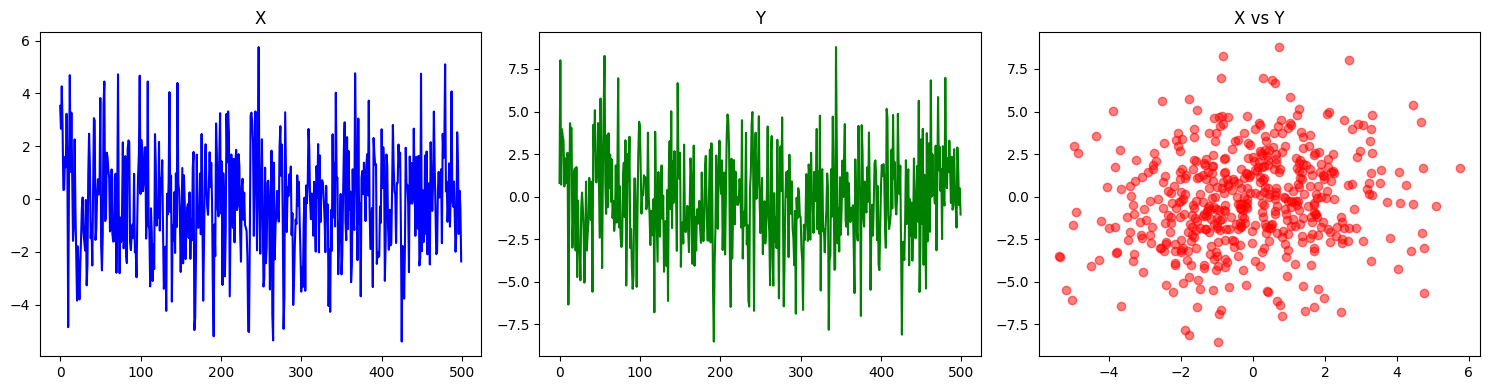


X → Y: TE = 0.7263, p-value = 0.0000
Y → X: TE = 0.4824, p-value = 0.4780


In [19]:
# ----------------------------
# Step 1: Generate the data
# ----------------------------

#  X is values 0-501, times 0.2 and add noise.
#  Y is values of X plus noise.

np.random.seed(0)
n = 500
x = np.zeros(n + 1)
y = np.zeros(n + 1)

for i in range(n):
    x[i + 1] = 0.2 * x[i] + np.random.normal(0, 2)
    y[i + 1] = x[i] + np.random.normal(0, 2)

x = x[1:]
y = y[1:]

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].plot(x, color="blue")
axes[0].set_title("X")
axes[1].plot(y, color="green")
axes[1].set_title("Y")
axes[2].scatter(x, y, alpha=0.5, color="red")
axes[2].set_title("X vs Y")
plt.tight_layout()
plt.show()

# ----------------------------
# Step 2: Bin the continuous data - put data into categories (bins)
# ----------------------------
def bin_series(series, bins=10):
    return np.digitize(series, bins=np.linspace(np.min(series), np.max(series), bins))

x_binned = bin_series(x, bins=10)
y_binned = bin_series(y, bins=10)

# ----------------------------
# Step 2: Define bootstrap/surrogate function
# Bootstrapping is shuffle the values to remove the time element and recalculate TE multiple times to confirm significance.
# ----------------------------
def bootstrap_te_significance(source, target, k=1, nboot=1000, seed=0):
    np.random.seed(seed)
    obs_te = te.transfer_entropy(source, target, k=k)

    surrogate_te = []
    for _ in range(nboot):
        source_shuffled = np.random.permutation(source)
        te_val = te.transfer_entropy(source_shuffled, target, k=k)
        surrogate_te.append(te_val)

    surrogate_te = np.array(surrogate_te)
    # p-value = fraction of surrogate TE >= observed TE
    p_value = np.mean(surrogate_te >= obs_te)

    return obs_te, p_value, surrogate_te

# ----------------------------
# Step 3: Run for X → Y
# ----------------------------
obs_te_xy, p_xy, surrogate_xy = bootstrap_te_significance(x_binned, y_binned, k=1, nboot=1000)
obs_te_yx, p_yx, surrogate_yx = bootstrap_te_significance(y_binned, x_binned, k=1, nboot=1000)

# ANSI escape codes for bold on/off
BOLD = "\033[1m"
RESET = "\033[0m"

def format_pval(p):
    return f"{BOLD}{p:.4f}{RESET}" if p < 0.01 else f"{p:.4f}"

print()
print(f"X → Y: TE = {obs_te_xy:.4f}, p-value = {format_pval(p_xy)}")
print(f"Y → X: TE = {obs_te_yx:.4f}, p-value = {format_pval(p_yx)}")

# p-values: < 0.001 '***', < 0.01 '**', < 0.05 '*', < 0.1 '.'   Smaller the P value, the more significant the transfer. 0.1 or over is "meh"

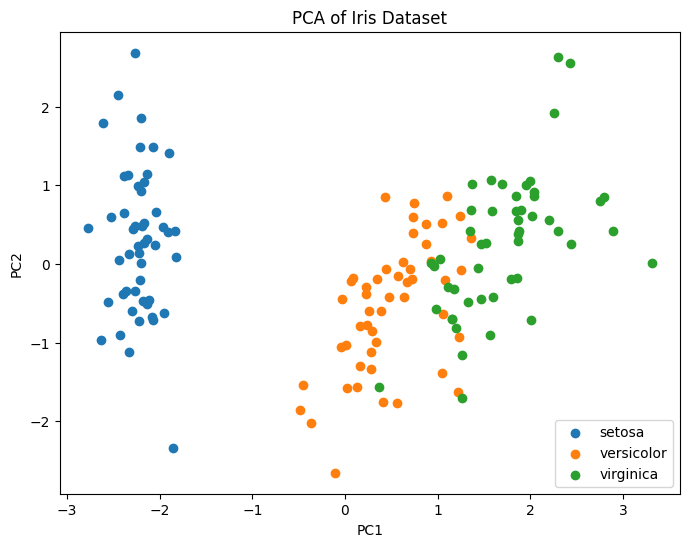

PCA Components (Loadings):
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
PC1           0.521066         -0.269347           0.580413          0.564857
PC2           0.377418          0.923296           0.024492          0.066942
PC3           0.719566         -0.244382          -0.142126         -0.634273
PC4          -0.261286          0.123510           0.801449         -0.523597

PC1: 72.96%
PC2: 22.85%
PC3: 3.67%
PC4: 0.52%


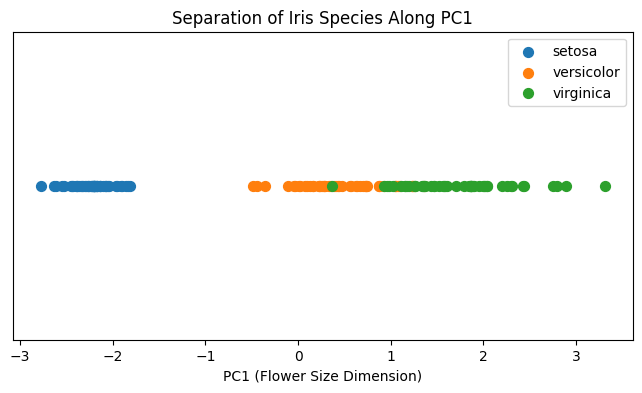

In [17]:
# Load the iris dataset
iris_data = load_iris()
X = iris_data.data       # Features (columns 1-4 in R)
y = iris_data.target     # Species labels as numbers
species_names = iris_data.target_names[y]  # Convert to species names

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA()
pca_scores = pca.fit_transform(X_scaled)

# Create a DataFrame with PCA scores and species
scores_df = pd.DataFrame(pca_scores, columns=[f'PC{i+1}' for i in range(X.shape[1])])
scores_df['Species'] = species_names

# Plot the first two principal components
plt.figure(figsize=(8,6))
for species in np.unique(species_names):
    plt.scatter(scores_df.loc[scores_df['Species'] == species, 'PC1'],
                scores_df.loc[scores_df['Species'] == species, 'PC2'],
                label=species)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Iris Dataset')
plt.legend()
plt.show()

# Print PCA components (loadings)
print("PCA Components (Loadings):")
print(pd.DataFrame(pca.components_, columns=iris_data.feature_names, index=[f'PC{i+1}' for i in range(X.shape[1])]))
print()

# Variance explained by each principal component
var_explained = pca.explained_variance_ratio_
for i, var in enumerate(var_explained):
    print(f"PC{i+1}: {var*100:.2f}%")

# PC1 scores
pc1_scores = pca_scores[:, 0]

# Plot PC1 for each species
plt.figure(figsize=(8, 4))
for species in np.unique(species_names):
    plt.scatter(pc1_scores[species_names == species],
                [0]*sum(species_names == species),  # all points on y=0 for a 1D view
                label=species, s=50)  # s=50 makes the points bigger

plt.xlabel('PC1 (Flower Size Dimension)')
plt.yticks([])  # hide y-axis since it's not informative
plt.title('Separation of Iris Species Along PC1')
plt.legend()
plt.show()